## Insight on product categories
#### Sản phẩm được xác định duy nhất thông qua biến StockCode và mô tả ngắn Description. Mục đích của notebook để nhóm các sản phẩm vào các loại khác nhau
### I. Mô tả sản phẩm
#### 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
nltk.download('averaged_perceptron_tagger')
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/thangnd/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, column = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()

    for s in dataframe[column]:
        if pd.isnull(s): continue
        # Convert all word to lower
        lines = s.lower()
        # tokenized word of lines
        tokenized = nltk.word_tokenize(lines)
        # pos_tag assigns to such as noun, verb, adjective, etc -> select noun
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t) # reduce word eg: cared --> care
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(column,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [3]:
df_init = pd.read_csv('../dataset/data_eda02.csv')
df_init

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,QuantityCancled,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,NaN,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,NaN,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,NaN,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,NaN,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,NaN,20.34
...,...,...,...,...,...,...,...,...,...,...,...
386932,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0,NaN,10.20
386933,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0,NaN,12.60
386934,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0,NaN,16.60
386935,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0,NaN,16.60


In [4]:
df_product = pd.DataFrame(df_init['Description'].unique()).rename(columns={0: 'Description'})

In [5]:
keywords, keyword_roots, keywords_select, count_keywords = keywords_inventory(df_product)

Nb of keywords in variable 'Description': 1462


##### keywords: Danh sách từ khóa được trích xuất
##### keywords_roots: Từ điển chứa khóa là các từ gốc và giá trị là danh sách các từ được infer từ từ gốc đó.
##### count_keywords: Từ điển liệt kê tần suất xuất hiện của các từ được sử dụng.

In [10]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

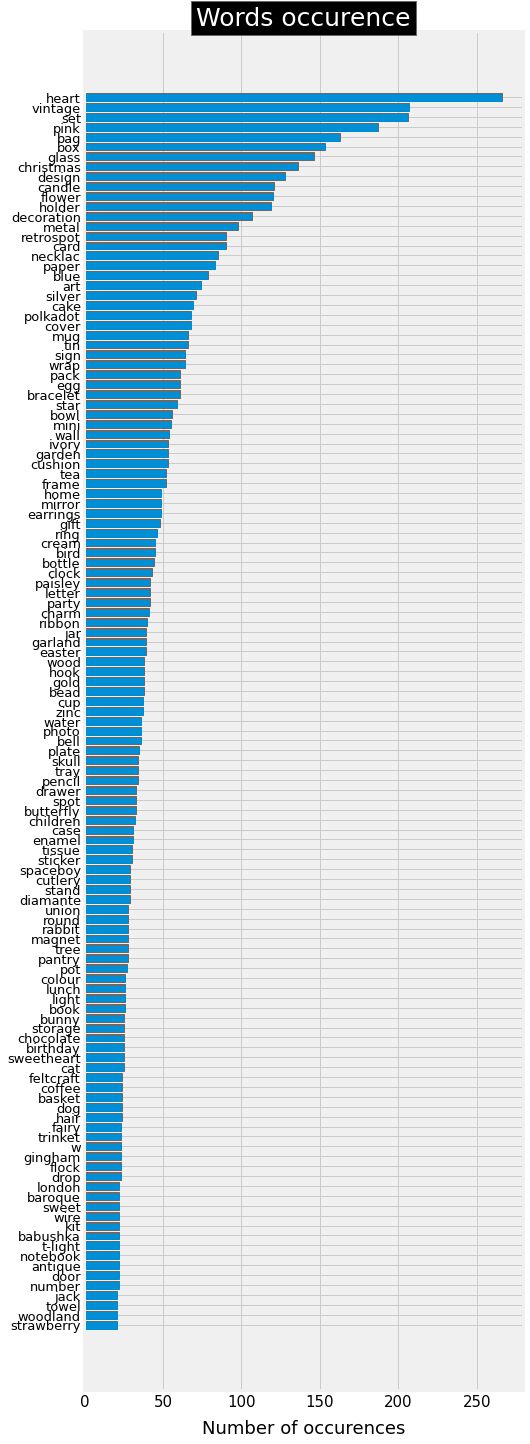

In [12]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

### II. Xác định phân loại sản phẩm
- Loại bỏ các từ không có ý nghĩa và có tần suất nhỏ hơn 13 lần.

In [17]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('Nb:', len(list_products))

Nb: 190


In [21]:
list_products

[['heart', 266],
 ['vintage', 207],
 ['set', 206],
 ['bag', 163],
 ['box', 153],
 ['glass', 146],
 ['christmas', 136],
 ['design', 128],
 ['candle', 121],
 ['flower', 120],
 ['holder', 119],
 ['decoration', 107],
 ['metal', 98],
 ['retrospot', 90],
 ['card', 90],
 ['necklac', 85],
 ['paper', 83],
 ['art', 74],
 ['silver', 71],
 ['cake', 69],
 ['polkadot', 68],
 ['cover', 68],
 ['mug', 66],
 ['tin', 66],
 ['sign', 64],
 ['wrap', 64],
 ['pack', 61],
 ['egg', 61],
 ['bracelet', 61],
 ['star', 59],
 ['bowl', 56],
 ['mini', 55],
 ['wall', 54],
 ['ivory', 53],
 ['garden', 53],
 ['cushion', 53],
 ['tea', 52],
 ['frame', 52],
 ['home', 49],
 ['mirror', 49],
 ['earrings', 49],
 ['gift', 48],
 ['ring', 46],
 ['cream', 45],
 ['bird', 45],
 ['bottle', 44],
 ['clock', 43],
 ['paisley', 42],
 ['letter', 42],
 ['party', 42],
 ['charm', 41],
 ['ribbon', 40],
 ['jar', 39],
 ['garland', 39],
 ['easter', 39],
 ['wood', 38],
 ['hook', 38],
 ['gold', 38],
 ['bead', 38],
 ['cup', 37],
 ['zinc', 37],
 ['wate

- Mã hóa dữ liệu
- Định nghĩa ma trận X với mỗi phần tử aij = 1 nếu mô tả sẩn phẩm i chứa từ j và bằng 0 trong TH ngược lại.

In [18]:
df_cleaned = df_init.copy(deep=True)
list_prod = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_prod))

In [19]:
X

,heart,vintage,set,bag,box,glass,christmas,design,candle,flower,...,milk,funky,tidy,plant,diner,house,square,lace,wallet,point
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(list_prod):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [26]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       956                 
1<.<2       1006                
2<.<3       674                 
3<.<5       605                 
5<.<10      471                 
.>10        121                 


- Tạo các cụm của sản phẩm

In [30]:
matrix = X.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10325968146641108
For n_clusters = 4 The average silhouette_score is : 0.12906940157083546
For n_clusters = 5 The average silhouette_score is : 0.14973456056494078
For n_clusters = 6 The average silhouette_score is : 0.14808443540678218
For n_clusters = 7 The average silhouette_score is : 0.1485485719978263
For n_clusters = 8 The average silhouette_score is : 0.14870857503955143
For n_clusters = 9 The average silhouette_score is : 0.1472702493204091


In [31]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.15029176755736007
